# Variational Auto-Encoder Model
---
A Variational Auto-Encoder is very similar to the previously introduced 'standard' auto-encoder. There are 2 main difference though.
1. With the 'regular' auto-encoder the latent features were continous values. In the case of a variational auto-encoder, the latent features are distributions over the latent space. The encoder outputs various means and standard deviations that describe the latent space
2. The loss is no longer just a reconstruction loss, in case of the variational auto-encoder we do use the same reconstruction loss as earlier but we add in a KL-Divergance. This forces the latent distributions to more or less be 'normally' distributed and avoids them becoming too narrow.

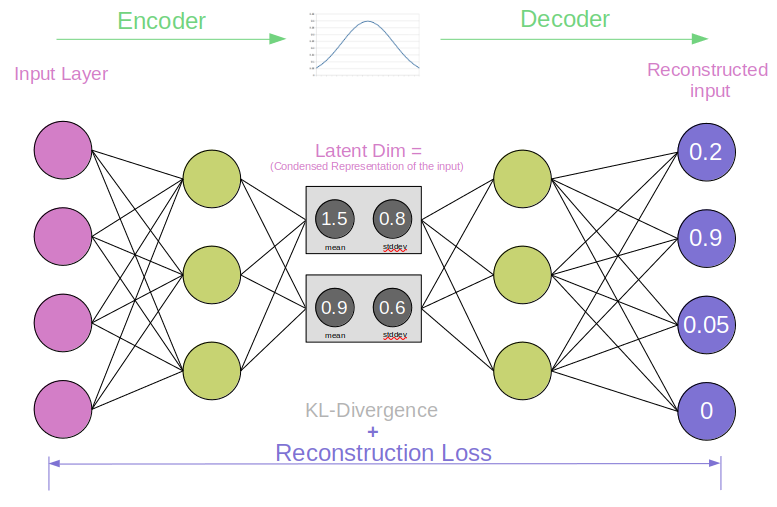

Because the latent space consists of distributions that are more continous than the regular auto-encoder, variational auto-encoders latent spaces are better to sample form.  By sampling from the distributions and running those through the decoder we can create new data. Variational Auto-Encoders are therefore considered a form of **Generative Model**.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt

import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../data/bs140513_032310.csv'

## Define Features
All features for this model are set up as `FeatureOneHot`, which will make our models encode them as a **OneHot** vector. 

Other than in the previous examples we also encode the **amount** as One-Hot vector, we do this by first turning it into a `FeatureBin` and then one-hot encoding the binned feature.

We also define the fraud-label but we will only be using it for the tesing phase. The fraud label is **not used during training**.

In [5]:
age      = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender   = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount   = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud    = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)

amount_oh   = ft.FeatureOneHot('amount_one_hot', ft.FEATURE_TYPE_INT_8, amount_binned)
age_oh      = ft.FeatureOneHot('age_one_hot', ft.FEATURE_TYPE_INT_8, age)
gender_oh   = ft.FeatureOneHot('gender_one_hot', ft.FEATURE_TYPE_INT_8, gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', ft.FEATURE_TYPE_INT_8, merchant)
category_oh = ft.FeatureOneHot('category_one_hot', ft.FEATURE_TYPE_INT_8, category)
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

# TensorDefinitions
td_oh    = ft.TensorDefinition('one-hot', [amount_oh, age_oh, gender_oh, merchant_oh, category_oh])
td_label = ft.TensorDefinition('label', [fraud_label])

with en.EnginePandas() as e:
    ti = e.np_from_csv((td_oh, td_label), file, inference=False)

print(ti.shapes)
print(ti.dtype_names)

2023-05-07 14:17:26.612 eng1n3.common.engine           INFO     Start Engine...
2023-05-07 14:17:26.612 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-05-07 14:17:26.613 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-05-07 14:17:26.613 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/bs140513_032310.csv
2023-05-07 14:17:27.076 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-05-07 14:17:27.117 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 2 numpy arrays


((594643, 105), (594643, 1))
('uint8', 'int8')


## Create Data-Sets and Loaders
Again, we **filter out the fraudulent** transactions for our training and validation test. The training and validation datasets will only contain non-fraudulent records. The test dataset will contain **both** fraudulent and non-fraudulent transactions.

In [6]:
train, val, test = ti.split_sequential(30000, 100000)

# Filter. Only keep non-fraud records with label 0. 
train = train.filter_label(0)
val   = val.filter_label(0)

batch_size = 128
# Creating DataSets
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

# Creating an oversampler for the training set.
train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

# Setting up the Dataloaders.
train_dl = train_ds.data_loader(data_device, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(data_device, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(data_device, batch_size, num_workers=2)

print(train.shapes)
print(val.shapes)
print(test.shapes)

((458847, 105), (458847, 1))
((29670, 105), (29670, 1))
((100000, 105), (100000, 1))


## Create AutoEncoder Model
The next cell creates the variational auto-encoder model.

In this example we ask the models `encoder` to first condense the input (all our OneHot Features) into a 16 size *hidden layer* and then to a 3 size **latent dimension**. Then the `decoder` does the inverse, it expands the 3 size latent layer into a 16 size hidden layern then the 16 size hidden layer gets exanded into the size of the original input.

This model is almost exactly the same as the first auto-encoder, except for the little detail where the encoder encodes both a `mu` and a `sigma` layer. (Distributions rather than continous variables)

Because the input is binary, the last layer of the decoder applies a `Sigmoid`. The model considers the entire output size as all being individual classes, so we have a single-label, multi-class style prediction. Each 'class' will incur al loss, and that loss will be averaged out.

In [7]:
class VariationalAutoEncoderModel(mp.VariationalAutoEncoder):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(VariationalAutoEncoderModel, self).__init__(model_configuration)
        self.encoder = self.create_linear_encoder(layer_sizes=(16, 3), dropout=0.1, bn_interval=0)
        self.decoder = self.create_linear_decoder(layer_sizes=(3, 16), dropout=0.1, bn_interval=0)

    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # The forward creates the latent representation by calling the encoder.
        latent = self.encoder(x[0])
        # Then feeds the latent representation into the decoder.
        o = self.decoder(latent)
        # Little trick here. We can return 'o' as-is, the VAE decoder returns a Tuple.
        return o
        
model = VariationalAutoEncoderModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

VariationalAutoEncoderModel(
  Number of parameters : 3647. Loss : SingleLabelVAELoss(), mean, 1.0
  (encoder): LinearVAEEncoder(
    (layers): Sequential(
      (head): TensorDefinitionHead(Name=one-hot, lc=Binary)
      (linear_encoder): LinLayer(
        (layers): Sequential(
          (lin_layer_01): Linear(in_features=105, out_features=16, bias=True)
        )
      )
    )
    (mu): Linear(in_features=16, out_features=3, bias=True)
    (sigma): Linear(in_features=16, out_features=3, bias=True)
  )
  (decoder): LinearVAEDecoder(
    (layers): Sequential(
      (linear_decoder): LinLayer(
        (layers): Sequential(
          (lin_layer_01): Linear(in_features=3, out_features=16, bias=True)
          (lin_act_01): ReLU()
          (lin_dropout_01): Dropout(p=0.1, inplace=False)
        )
      )
      (tail): Linear(in_features=16, out_features=105, bias=True)
      (final-act): Sigmoid()
    )
  )
)

## Find Learning Rate
For auto-encoders we will use a learning rate that is relatively close to the dropoff point, auto-encoders seem to train better with lower learning rates.

Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 260.47it/s]                                                    


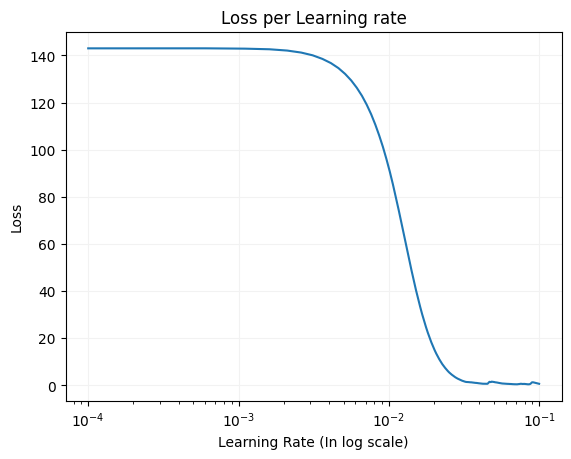

In [8]:
min_lr = 1e-4
max_lr = 1e-1
m_lr = VariationalAutoEncoderModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, model_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);

## Train

In [9]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=8e-3)
# Set up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer for [EPOCH] epochs
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 3817/3817 [00:04<00:00, 794.75it/s, t_loss=0.0689, v_loss=0.0681]                              


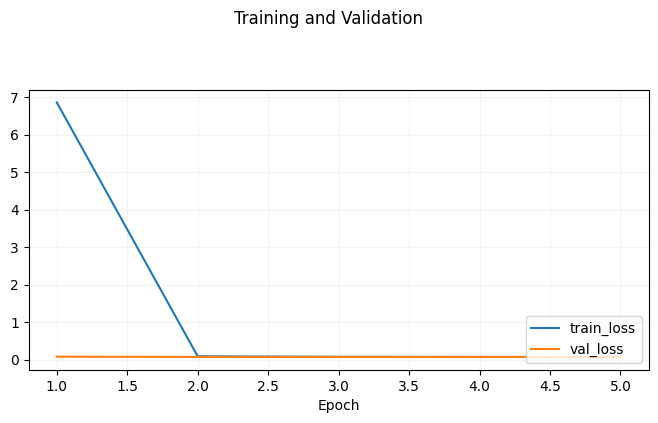

In [10]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

## Testing the model
As we test this variational auto-encoder we see that it ouputs a slighly broader range of loss/reconstruction error values. And it does seem to seperate out the values a bit more, the lower range is almost exclusively non-fraud, the upper range almost exclusively fraud.

We'll use a 0.21 loss threshold to test the performance of this model. Thus anything above 0.21 will be considered fraud, anything below, non-fraud.

Calculating loss in 782 steps: 100%|████████| 782/782 [00:00<00:00, 1560.22it/s]


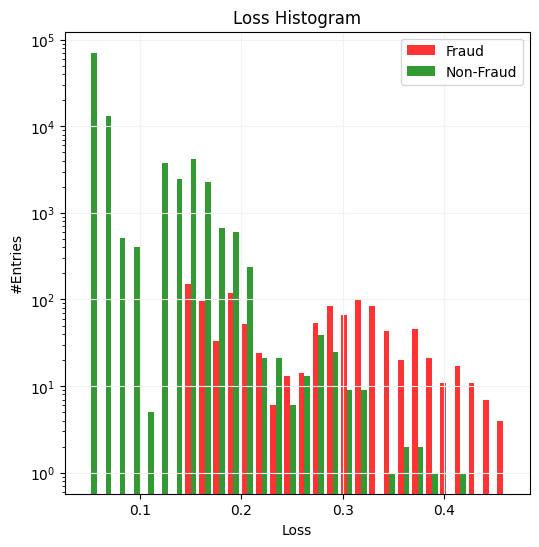

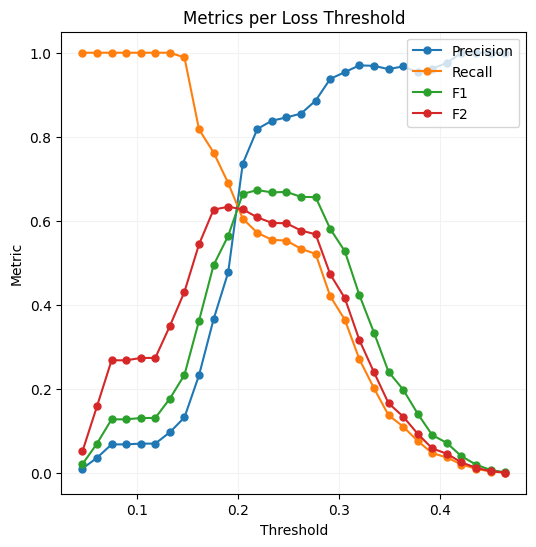

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.79      0.59      0.67      1074

    accuracy                           0.99    100000
   macro avg       0.89      0.79      0.84    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9886
ap score  : 0.6968
-----------------------------------------------------


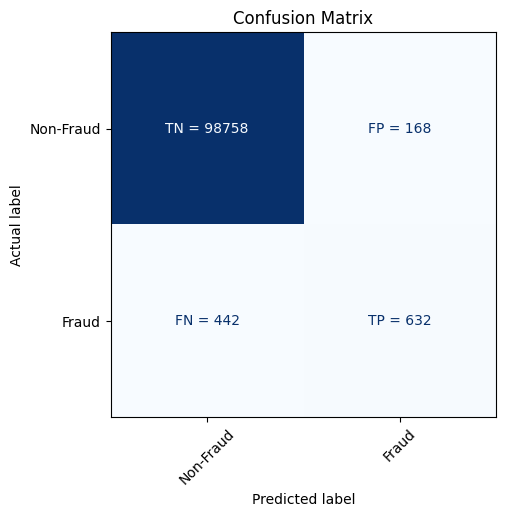

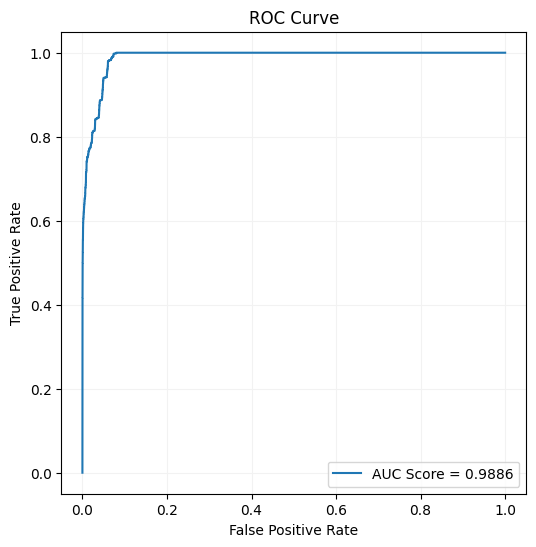

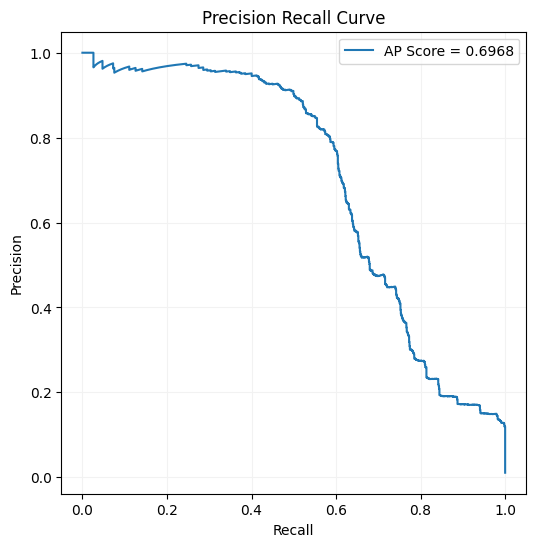

In [11]:
t = mp.Tester(model, model_device, test_dl)
results = t.test_results_loss()
mplt.TestPlot.plot_loss_binary(results, 30, fig_size=(6,6));
mplt.TestPlot.plot_loss_metrics(results, 30, fig_size=(6,6));
mplt.TestPlot.print_binary_classification_report(results, threshold=0.21)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5), threshold=0.21);
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6));
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

In the loss histogram plot we can see that we have a large with low losses where we only have non-fraud records. The plot maybe does not do this justice, but we can see that below the loss threshold of 0.14 we have about 90.000 records that all are non-fraud.

This means that by running this model we can more or less immediately discard 90% of the records are being fraud. **Anything below a loss of 0.14 is guaranteed to be non-fraud** (in our data).

(Small note on data-science best practices; it is not considered good practice to set a threshold based on test-data, this would be considered iffy. The better practice would be to do it on the training and validation set and then test on the testing set. Don't do what we just did in real life)

In [12]:
np.count_nonzero(results.y_prd[0] < 0.14), np.count_nonzero((results.y_prd[0] < 0.14) & (results.y[0] == 1.0))

(90325, 0)

## Visualizing the latent space.
We can have some fun trying to visualize what the latent space looks like. In order to do so, we will create a model that uses the `encoder` only, run some test data through and plot the output. 

### Create model
Our variational encoder outputs 2 vectors. One for the mu's and one for the sigma's. Here we return te **mu only** because we would like the plot the average only.

In [13]:
class VariationalEncoderOnlyModel(mp.VariationalAutoEncoder):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(VariationalEncoderOnlyModel, self).__init__(model_configuration)
        self.encoder = self.create_linear_encoder(layer_sizes=(16, 3), dropout=0.1, bn_interval=0)

    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # The forward creates the latent representation by calling the encoder.
        mu, s = self.encoder(x[0])
        # Only return the average vector.
        return (mu,)
        
enc_model = VariationalEncoderOnlyModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
enc_model

VariationalEncoderOnlyModel(
  Number of parameters : 1798. Loss : SingleLabelVAELoss(), mean, 1.0
  (encoder): LinearVAEEncoder(
    (layers): Sequential(
      (head): TensorDefinitionHead(Name=one-hot, lc=Binary)
      (linear_encoder): LinLayer(
        (layers): Sequential(
          (lin_layer_01): Linear(in_features=105, out_features=16, bias=True)
        )
      )
    )
    (mu): Linear(in_features=16, out_features=3, bias=True)
    (sigma): Linear(in_features=16, out_features=3, bias=True)
  )
)

Then we copy across the parameters from the trained model into this model. At this point, we have a model that has the same encoder as the trained model, with the exact same parameters.

In [14]:
with torch.no_grad():
    enc_model.encoder.layers.linear_encoder.layers.lin_layer_01.weight.copy_(
        model.encoder.layers.linear_encoder.layers.lin_layer_01.weight
    )
    enc_model.encoder.mu.weight.copy_(model.encoder.mu.weight)
    enc_model.encoder.sigma.weight.copy_(model.encoder.sigma.weight)

### Sample and Test data
Now let's do some sampling and run the model, this piece of code samples all the fraud from our test data set and a random sample of non-fraud.

In [15]:
N_FRAUD_SAMPLE_SIZE = 5000

# Get the labels
y = torch.squeeze(test_ds[:][1])
# First Separate out the Fraud from the Non-Fraud
fraud=test_ds[np.where(y==1.0)]
n_fraud=test_ds[np.where(y==0.0)]
# Now Sample a number of Non-Fraud records
sample_index = torch.randperm(n_fraud[0].shape[0])[:N_FRAUD_SAMPLE_SIZE]
n_fraud = n_fraud[0][sample_index]

Run both samples through the model and convert to numpy

In [16]:
enc_model.eval()
with torch.no_grad():
    nf = enc_model((n_fraud,))[0].detach().numpy()
    f  = enc_model((fraud))[0].detach().numpy()

### Plot Latent Space
This latent space looks very different than the 'standard' auto-encoder. We can see that most points get plotted in a more or less straight line. This is the KL-divergence 'insisting' the distribution is normally distributed. This force the mu's to be close to 0.

Other than with the 'standard' auto-encoder we do seem to have a spacial separation of the Fraud vs Non-Fraud records. The non-frauds are very densly packed onto the straight line.

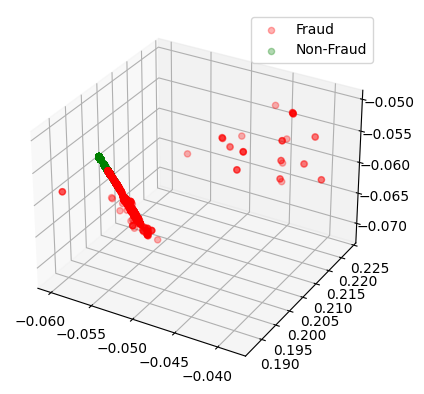

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for color, label, a in [('red', 'Fraud', f), ('green', 'Non-Fraud', nf)]:
    ax.scatter3D(a[:,0], a[:,1], a[:,2], color=color, label=label, alpha=0.3)
ax.legend()
ax.grid(True)
plt.show();

The spacial separation becomes even clearer when we plot in 2 plots. This opens up some opportunities. You'd be very much tempted to think that if you sample from the area that predominantly have fraud and run those through the decoder, you'd be able to create some new -previously unseen- fraud records.

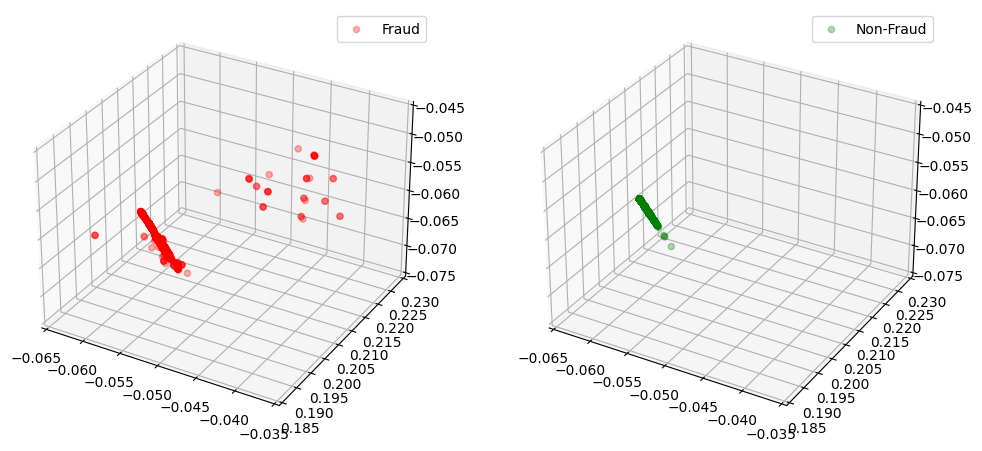

In [18]:
xticks = ax.get_xticks()
yticks = ax.get_yticks()
zticks = ax.get_zticks()
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,2,1, projection='3d')
for color, label, a in [('red', 'Fraud', f)]:
    ax1.scatter3D(a[:,0], a[:,1], a[:,2], color=color, label=label, alpha=0.3)
ax1.legend()
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_zticks(zticks)
ax1.grid(True)
ax2 = fig.add_subplot(1,2,2, projection='3d')
for color, label, a in [('green', 'Non-Fraud', nf)]:
    ax2.scatter3D(a[:,0], a[:,1], a[:,2], color=color, label=label, alpha=0.3)
ax2.legend()
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax2.set_zticks(zticks)
ax2.grid(True)
plt.show();

Finally let's run the decomposition again. As expected, we see distinct areas where we predominantly have fraud records.

As a small detail, compare the explained variance between this an the previous 'standard' auto-encoder. The decomposed space was much denser a streched more across the decomposed x-axis.

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# PCA the combined non-fraud and fraud.
p = pca.fit_transform(np.concatenate((nf,f)))
pca.explained_variance_ratio_

array([0.75704944, 0.23212469], dtype=float32)

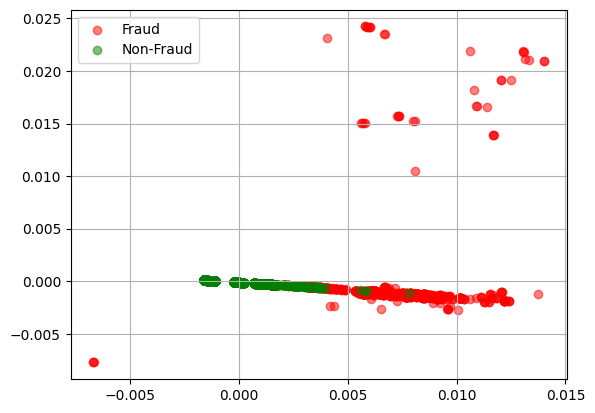

In [20]:
p_nf = p[:N_FRAUD_SAMPLE_SIZE]
p_f  = p[N_FRAUD_SAMPLE_SIZE:]
ax = plt.axes()
for color, label, a in [('red', 'Fraud', p_f), ('green', 'Non-Fraud', p_nf)]:
    ax.scatter(a[:,0], a[:,1], color=color, label=label, alpha=0.5)
plt.legend()
plt.grid(True)
plt.show()

## Conclusion
This gives us a second example of an auto-encoder, it gave us a latent space that looks a lot different than than the previous 'standard' auto-encoder. It had a better ability to separate out fraud from non-fraud. Also we'd be tempted to think it might be more useful to create new fraud records because the latent space has distinct areas where we only have fraud.